In [10]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import time

sys.path.insert(0, '../codes/')
import bulkMotion
import misc

from mintpy.utils import readfile, utils as ut, plot as pp
from mintpy.objects.coord import coordinate


font_size=30
plt.rcParams.update({'font.size': font_size})

In [14]:
dir = '/marmot-nobak/olstephe/InSAR/Makran/T86a/mintpy/merged_files/reorder_corrections'

## Read pre-defined paths
my_json = '../inputs/brief.json'
with open(my_json) as file:
    brief = json.load(file)

pathDir =   {"Makran a086": 
             {
                 "dem"         : "/marmot-nobak/ykliu/makran/a086/dem_resamp_a086/a086.dem",
                 "geo"         : "sub_geometryGeo_merge.h5",
                 "home"        : "/marmot-nobak/olstephe/InSAR/Makran/T86a/mintpy/merged_files",
                 "mask"        : None,
                 "proc"        : "topsApp",
                 "velo_raw"    : "reorder_corrections/merge_T86a_timeseries_fit_msk.h5",
                 "velo_ion"    : "reorder_corrections/merge_T86a_timeseries_fit_ion_msk.h5",
                 "velo_ERA5"   : "reorder_corrections/merge_T86a_timeseries_fit_ion_ERA5_msk.h5",
                 "velo_SET"    : "reorder_corrections/merge_T86a_timeseries_fit_ion_ERA5_SET_msk.h5",
                 "velo_demErr" : "reorder_corrections/merge_T86a_timeseries_fit_ion_ERA5_SET_demErr_msk.h5",
             }
            }


vDict = {
            "geo"         : "../in_h5/Makran_a086_Geo.h5",
            "dem"         : "../in_h5/Makran_a086.dem",
            "velo_raw"    : "../in_h5/Makran_a086_velR.h5",
            "velo_ion"    : "../in_h5/Makran_a086_velR_ion.h5",
            "velo_ERA5"   : "../in_h5/Makran_a086_velR_ion_ERA5.h5",
            "velo_SET"    : "../in_h5/Makran_a086_velR_ion_ERA5_SET.h5",
            "velo_demErr" : "../in_h5/Makran_a086_velR_ion_ERA5_SET_demErr.h5",
            "velo_bmModel": "../in_h5/Makran_a086_vel_bmModel.h5",
            "velo_bmCorr" : "../in_h5/Makran_a086_vel_bmCorr.h5"    
            }


In [23]:

def prepare_data(inDict):
    v = dict()
    v['Raw velocity']             = readfile.read(inDict['velo_raw'],    datasetName='velocity')[0]
    v['Ionosphere removed']       = readfile.read(inDict['velo_ion'],    datasetName='velocity')[0]
    v['ERA5 model removed']       = readfile.read(inDict['velo_ERA5'],   datasetName='velocity')[0]
    v['Solid Earth tide removed'] = readfile.read(inDict['velo_SET'],    datasetName='velocity')[0]
    v['DEM error removed']        = readfile.read(inDict['velo_demErr'], datasetName='velocity')[0]

    v['Bulk motion']              = readfile.read(inDict['velo_bmModel'], datasetName='velocity')[0]
    v['Bulk motion removed']      = readfile.read(inDict['velo_bmCorr'],  datasetName='velocity')[0]    
    
    v['SET & Dem error removed']  = v['DEM error removed']
    v['Iono']                     = - (v['Ionosphere removed']       -  v['Raw velocity'])
    v['ERA5']                     = - (v['ERA5 model removed']       -  v['Ionosphere removed'])
    v['SET']                      = - (v['Solid Earth tide removed'] -  v['ERA5 model removed'])
    v['DEM error']                = - (v['DEM error removed']        -  v['Solid Earth tide removed'])

    for k in v:
        v[k] = (v[k] - np.nanmedian(v[k])) * 1000.
    
    return v



In [26]:
kwargs

{'laloStep': 2,
 'wspace': 0.0,
 'suptity': 0.7,
 'alpha': 0.8,
 'shadeExg': 0.06,
 'shadeMin': -3000.0,
 'shadeMax': 5000.0,
 'refpoint': False,
 'dpi': 150,
 'pic_dir': '../pic',
 'cmap': 'RdYlBu_r',
 'suffix': '',
 'vlims': [[-20, 20], [-5, 5], [-5, 5], [-5, 5]]}

Plot data no. 1: <Raw velocity>
view.py /marmot-nobak/olstephe/InSAR/Makran/T86a/mintpy/merged_files/reorder_corrections/merge_T86a_timeseries_fit_msk.h5 velocity --fontsize 16 -u mm -v -20 20 --mask no --dem /marmot-nobak/ykliu/makran/a086/dem_resamp_a086/a086.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --noreference
Plot data no. 2: <Ionosphere removed>
view.py /marmot-nobak/olstephe/InSAR/Makran/T86a/mintpy/merged_files/reorder_corrections/merge_T86a_timeseries_fit_msk.h5 velocity --fontsize 16 -u mm -v -5 5 --mask no --dem /marmot-nobak/ykliu/makran/a086/dem_resamp_a086/a086.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --noreference
Plot data no. 3: <ERA5 model removed>
view.py /marmot-no

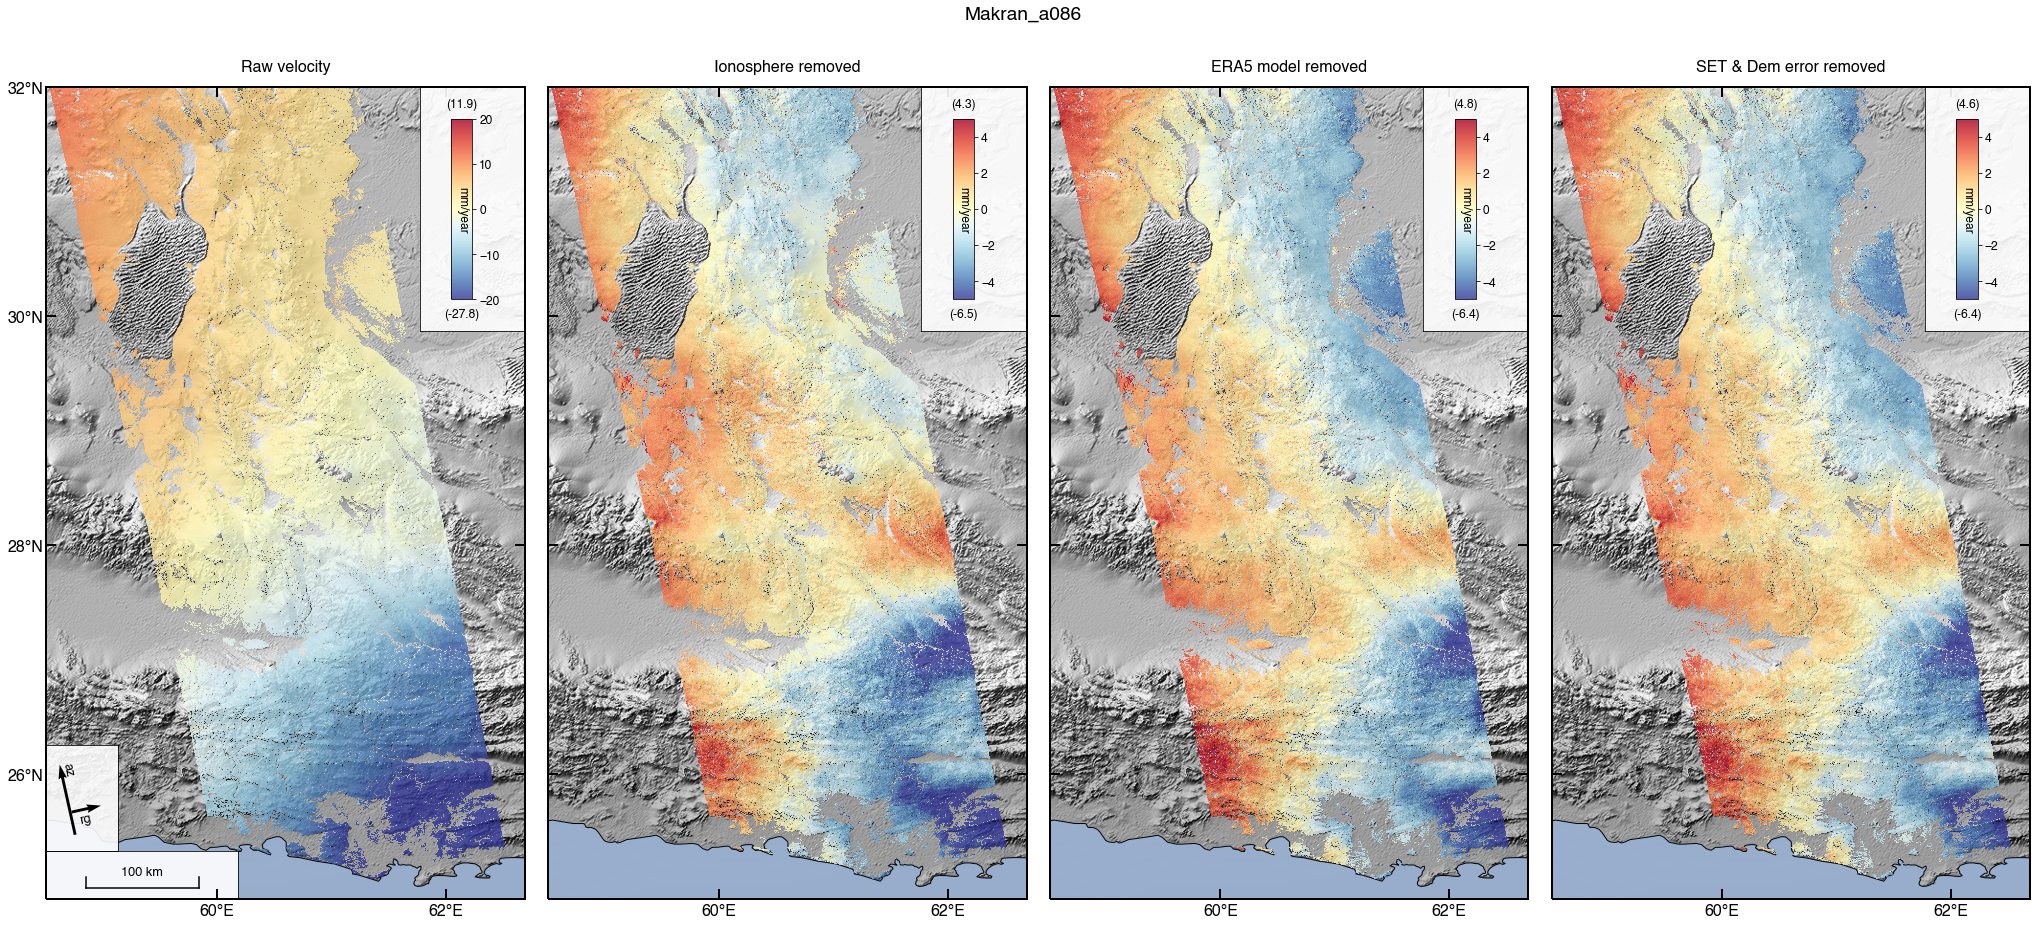

In [25]:
## Plot
dName = 'Makran a086'
name, track_id = dName.split(' ')
suptit             = f'{name}_{track_id}'
kwargs['vlims']    = [[-20 ,20], [-5,5], [-5,5], [-5,5]]

v_show = {ikey: v[ikey] for ikey in ['Raw velocity', 'Ionosphere removed', 'ERA5 model removed', 'SET & Dem error removed']}

fn = f"{kwargs['pic_dir']}/{name}_{track_id}{kwargs['suffix']}_CorrSeries_2.pdf"
misc.plot_imgs(v_show, atr, tobj.dem, super_title=suptit, outfile=fn, **kwargs)

In [7]:
# Input dictionary to obj
dName = 'Makran a086'
name, track_id = dName.split(' ')
tobj = bulkMotion.inputDict(pathDir[dName])

# Read attributes
atrfile =  tobj.velo_raw
atr     = readfile.read(atrfile, datasetName='velocity')[1]

## Read the velocity fields from data paths (pile them into dict())
v = dict()
if tobj.velo_raw    is not None:  v['Raw velocity']              = misc.read_img(tobj.velo_raw)
if tobj.velo_ion    is not None:  v['Ionosphere removed']        = misc.read_img(tobj.velo_ion)
if tobj.velo_ERA5   is not None:  v['ERA5 model removed']        = misc.read_img(tobj.velo_ERA5)
if tobj.velo_SET    is not None:  v['Solid Earth tide removed']  = misc.read_img(tobj.velo_SET)
if tobj.velo_demErr is not None:  v['DEM error removed']         = misc.read_img(tobj.velo_demErr)


## Get the difference
v['SET & Dem error removed'] = v['DEM error removed']
v['Iono']      = - (v['Ionosphere removed']       -  v['Raw velocity'])
v['ERA5']      = - (v['ERA5 model removed']       -  v['Ionosphere removed'])
v['SET']       = - (v['Solid Earth tide removed'] -  v['ERA5 model removed'])
v['DEM error'] = - (v['DEM error removed']        -  v['Solid Earth tide removed'])


In [29]:
tobj.dem

'/marmot-nobak/ykliu/makran/a086/dem_resamp_a086/a086.dem'

No reference point, remove a median from each dataset!!
Reference data: <Raw velocity>                 	 shifted by 8.478672981262207
Reference data: <Ionosphere removed>           	 shifted by 1.789309024810791
Reference data: <ERA5 model removed>           	 shifted by 1.517287015914917
Reference data: <Solid Earth tide removed>     	 shifted by 1.4678541421890259
Reference data: <DEM error removed>            	 shifted by 1.282490611076355
Reference data: <SET & Dem error removed>      	 shifted by 0.0
Reference data: <Iono>                         	 shifted by 6.207055568695068
Reference data: <ERA5>                         	 shifted by 0.13554930686950684
Reference data: <SET>                          	 shifted by 0.03318667411804199
Reference data: <DEM error>                    	 shifted by 0.17210933566093445
Plot data no. 1: <Raw velocity>
view.py /marmot-nobak/olstephe/InSAR/Makran/T86a/mintpy/merged_files/reorder_corrections/merge_T86a_timeseries_fit_msk.h5 velocity --fontsi

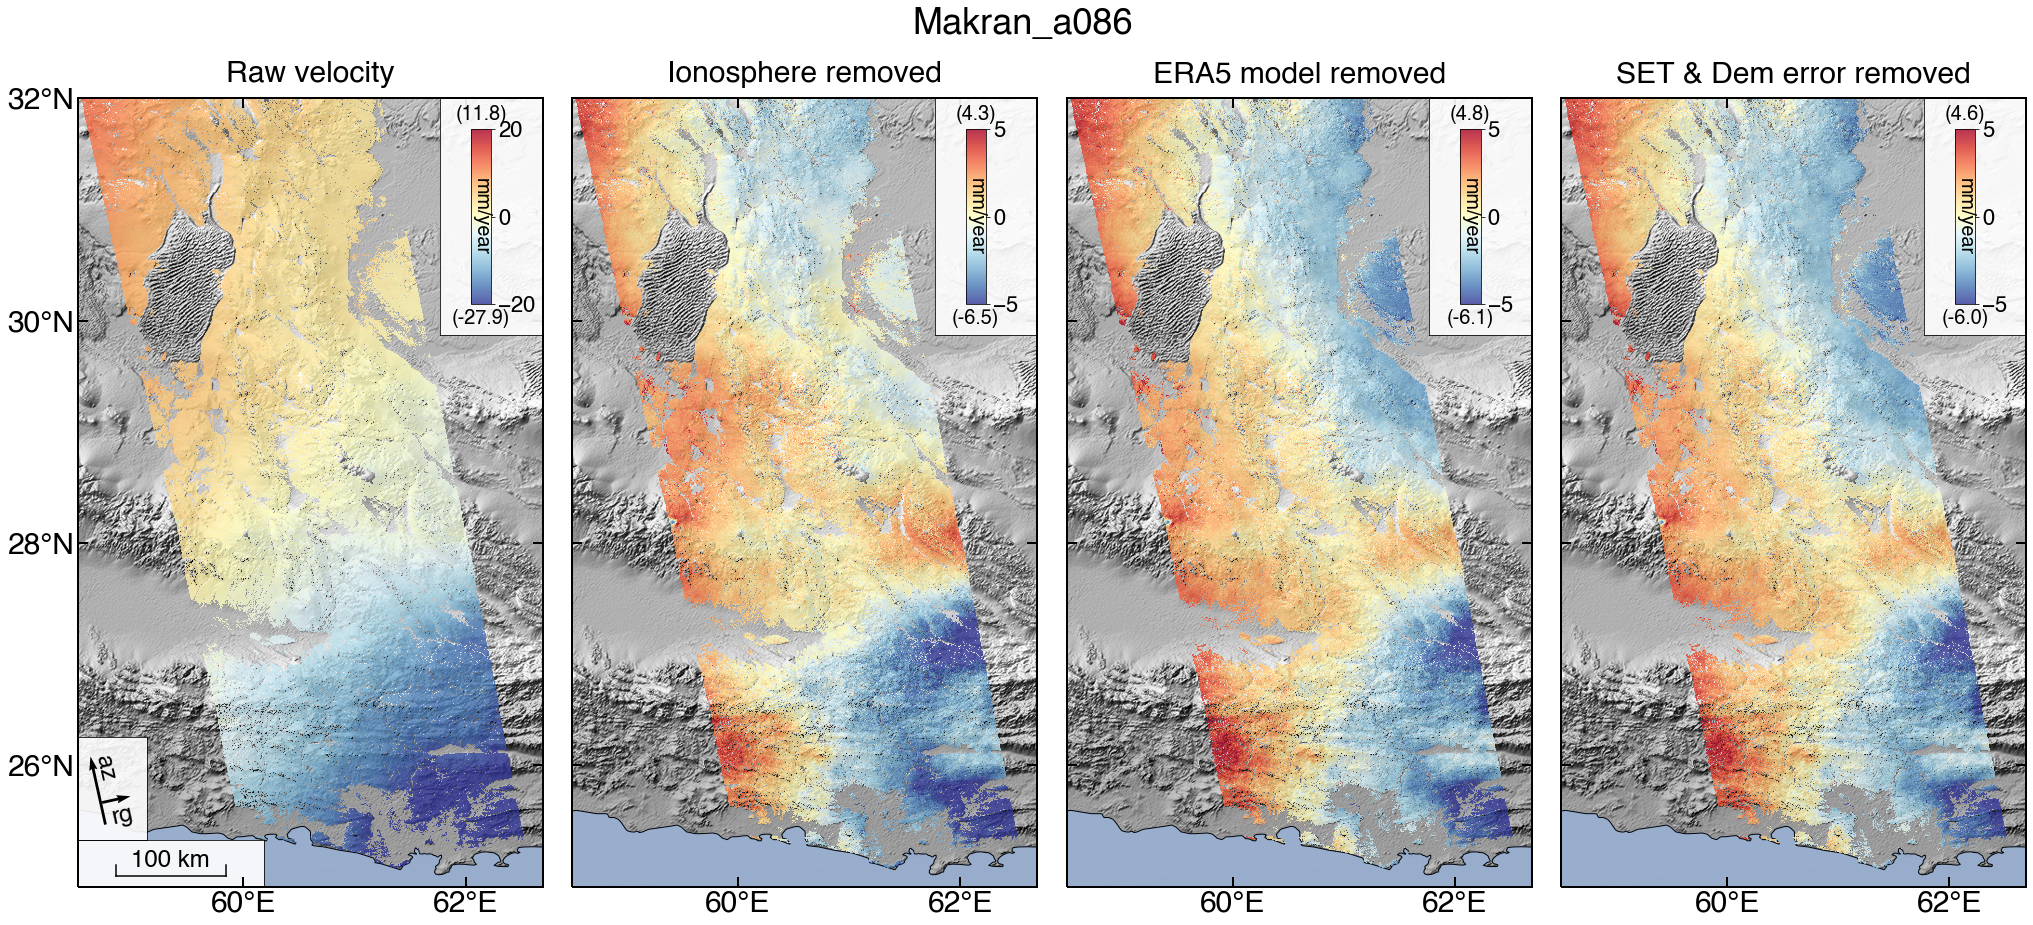

In [8]:
# Set plotting specs
kwargs = dict()
kwargs['laloStep'] = 2
kwargs['wspace']   = 0.
kwargs['suptity']  = 0.7
kwargs['alpha']    = 0.8
kwargs['shadeExg'] = 0.06
kwargs['shadeMin'] = -3e3
kwargs['shadeMax'] =  5e3
kwargs['refpoint'] = False
kwargs['dpi']      = 150

kwargs['pic_dir']  = '../pic'
kwargs['cmap']     = 'RdYlBu_r'
kwargs['suffix']   = ''



## Reference point for visualization the velocity
bulkMotion.reference_dataDict(v, atr, **kwargs)


## Plot
suptit             = f'{name}_{track_id}'
kwargs['vlims']    = [[-20 ,20], [-5,5], [-5,5], [-5,5]]
v_show = {ikey: v[ikey] for ikey in ['Raw velocity', 'Ionosphere removed', 'ERA5 model removed', 'SET & Dem error removed']}
fn = f"{kwargs['pic_dir']}/{name}_{track_id}{kwargs['suffix']}_CorrSeries.pdf"
misc.plot_imgs(v_show, atr, tobj.dem, super_title=suptit, outfile=fn, **kwargs)

Plot data no. 1: <Iono>
view.py /marmot-nobak/olstephe/InSAR/Makran/T86a/mintpy/merged_files/reorder_corrections/merge_T86a_timeseries_fit_msk.h5 velocity --fontsize 30 -u mm -v -20 20 --mask no --dem /marmot-nobak/ykliu/makran/a086/dem_resamp_a086/a086.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --noreference
Plot data no. 2: <ERA5>
view.py /marmot-nobak/olstephe/InSAR/Makran/T86a/mintpy/merged_files/reorder_corrections/merge_T86a_timeseries_fit_msk.h5 velocity --fontsize 30 -u mm -v -3 3 --mask no --dem /marmot-nobak/ykliu/makran/a086/dem_resamp_a086/a086.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --noreference
Plot data no. 3: <SET>
view.py /marmot-nobak/olstephe/InSAR/Makran/T86a/mintpy

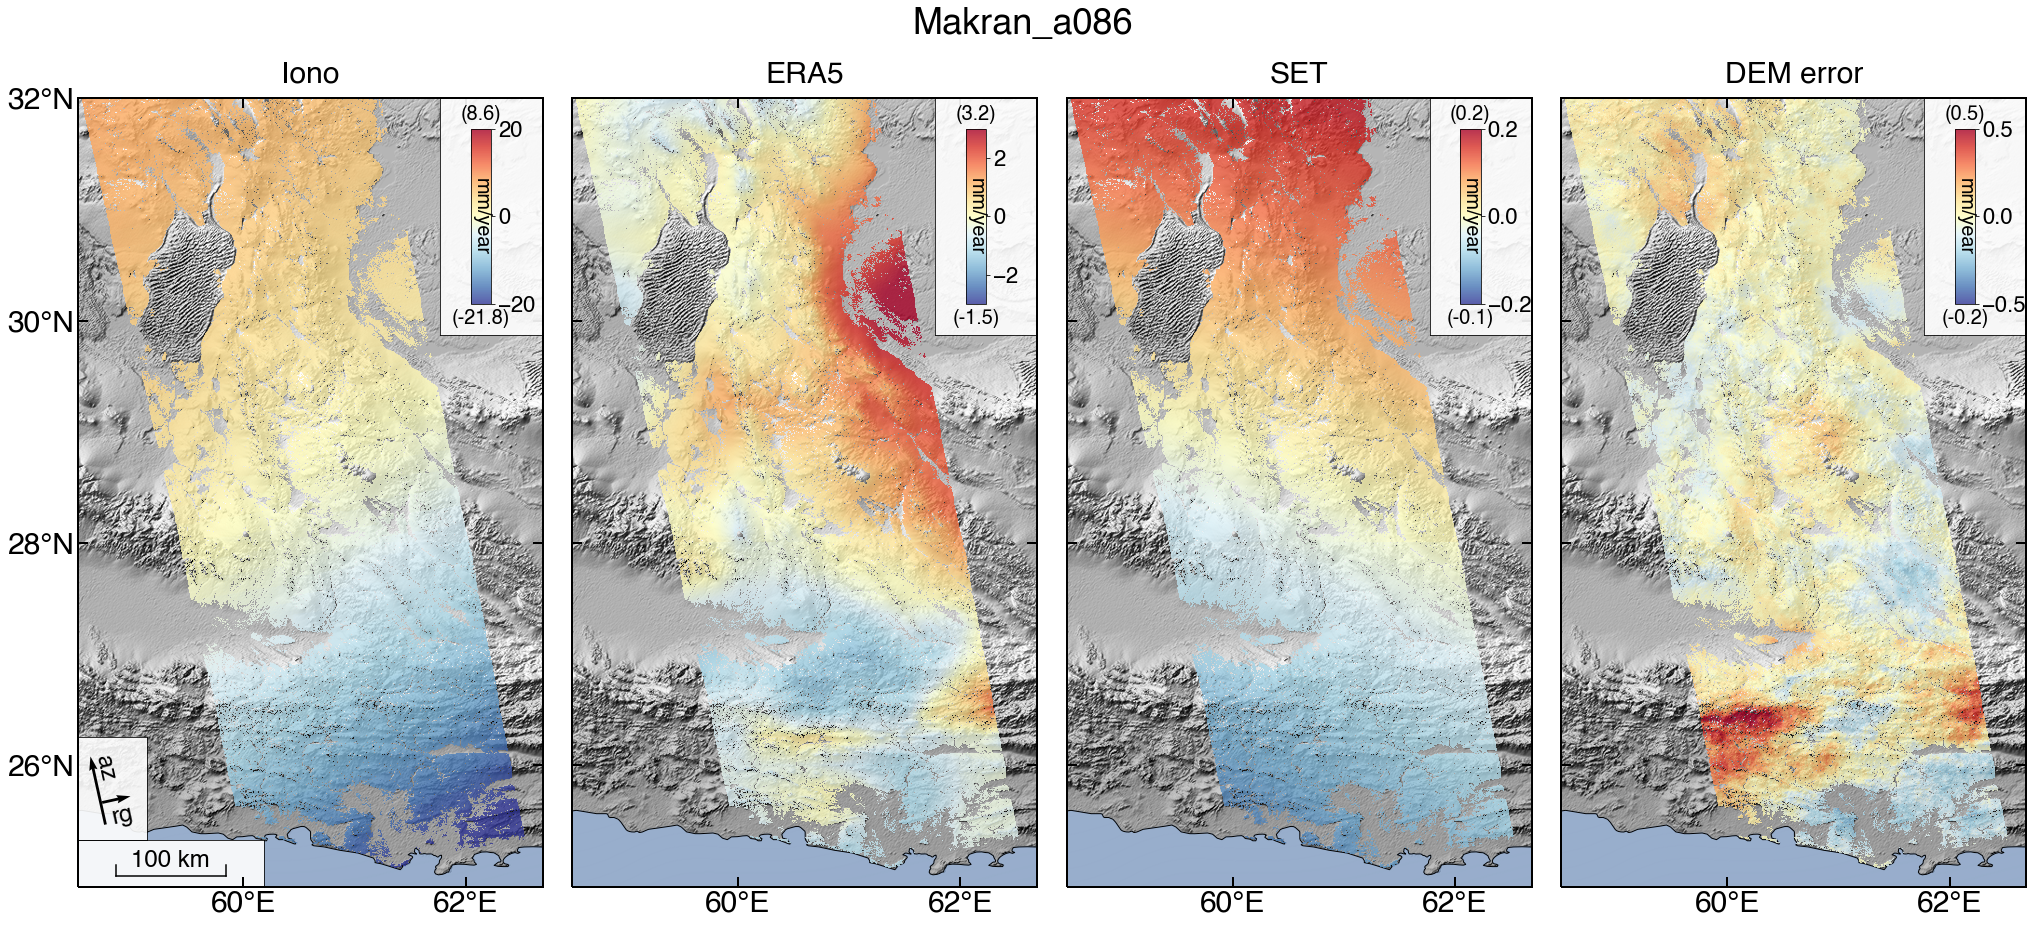

In [9]:
## Plot
suptit             = f'{name}_{track_id}'
kwargs['vlims']    = [[-20 ,20], [-3,3], [-.2,.2], [-.5,.5]]
v_show = {ikey: v[ikey] for ikey in ['Iono', 'ERA5', 'SET', 'DEM error']}
fn = f"{kwargs['pic_dir']}/{name}_{track_id}{kwargs['suffix']}_CorrItself.pdf"
misc.plot_imgs(v_show, atr, tobj.dem, super_title=suptit, outfile=fn, **kwargs)